In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import computeHoughTransformCoord, average_grayscale_along_line, computeResult

def draw_lines(img, lines, gray_thres):
    drawn_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for line in lines:
        x1, y1, x2, y2 = map(int, line[0])
        average_grayscale = average_grayscale_along_line(gray, x1, y1, x2, y2)
        if average_grayscale < gray_thres:
            drawn_img = cv2.line(drawn_img, (x1, y1), (x2, y2), (255, 0, 0), 1, cv2.LINE_AA)
        else:
            drawn_img = cv2.line(drawn_img, (x1, y1), (x2, y2), (0, 255, 0), 1, cv2.LINE_AA)
    plt.figure(figsize=[10, 10])
    plt.imshow(cv2.cvtColor(drawn_img, cv2.COLOR_BGR2RGB))
    plt.show()

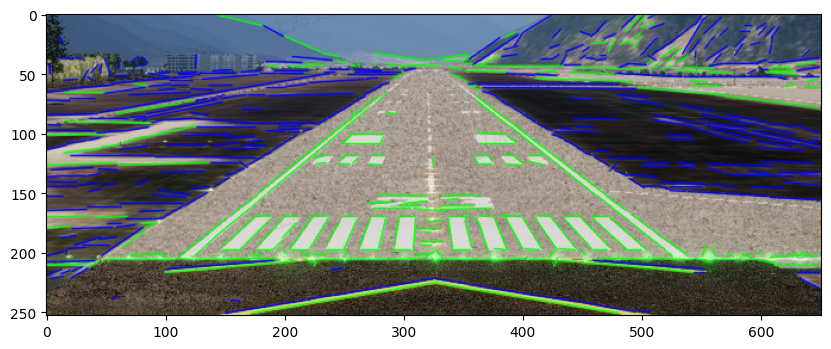

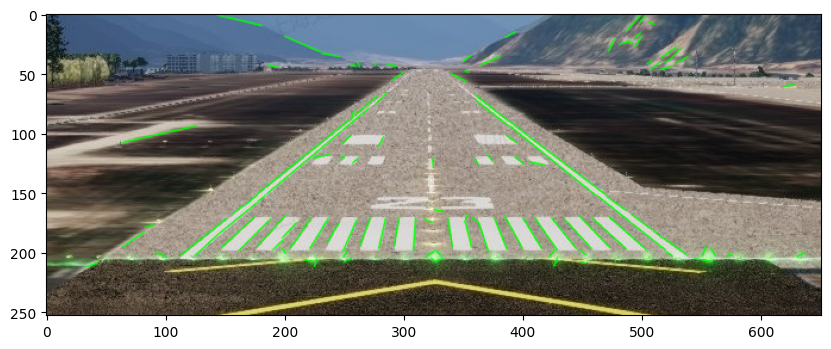

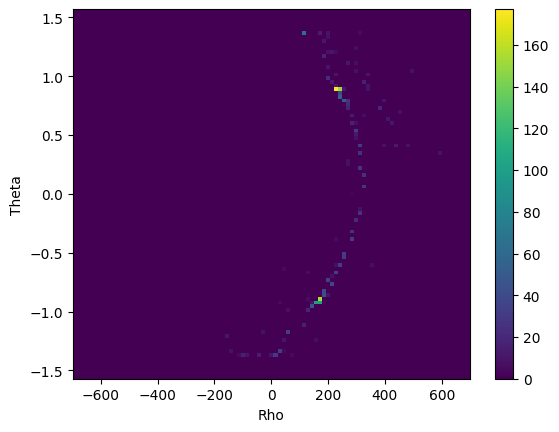

In [2]:
img = cv2.imread("images/504.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lsd = cv2.createLineSegmentDetector(scale=0.8, sigma_scale=0.6, quant=2.0, ang_th=22.5, log_eps=0.0, density_th=0.7, n_bins=1024)
lines, width, prec, nfa = lsd.detect(gray)

length_thres = 2
gray_thres = 120

# show original lines
draw_lines(img, lines, gray_thres)

thetaList = []
dList = []
rhoList = []
lineList = []
for line in lines:
    # check average gray scale
    x1, y1, x2, y2 = map(int, line[0])
    average_grayscale = average_grayscale_along_line(gray, x1, y1, x2, y2)
    if average_grayscale < gray_thres:
        continue
    
    # check short lines and horizontal lines
    theta, rho, d = computeHoughTransformCoord(x1, y1, x2, y2)
    if d < length_thres:
        continue
    if abs(np.abs(theta) - np.pi/2) < np.pi / 16 or np.abs(theta) > 1.5707963:
        continue

    thetaList.append(theta)
    dList.append(d)
    rhoList.append(rho)
    lineList.append(line)

# show filtered lines
draw_lines(img, lineList, gray_thres)

N = 100
Ntheta = N
Nrho = N
maxRho = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
# 创建一个网格
theta_bins = np.linspace(-np.pi/2, np.pi/2, num=Ntheta)
rho_bins = np.linspace(-maxRho, maxRho, num=Nrho)
totalLengthGrid = np.zeros((len(theta_bins) - 1, len(rho_bins) - 1))
thetaRhoGrid = [[[] for _ in range(len(rho_bins) - 1)] for _ in range(len(theta_bins) - 1)]

# 映射thetaList和rhoList到网格中
for theta, rho, d, line in zip(thetaList, rhoList, dList, lineList):
    theta_idx = np.digitize(theta, theta_bins) - 1
    rho_idx = np.digitize(rho, rho_bins) - 1
    # print(theta, rho, theta_idx, rho_idx)
    totalLengthGrid[theta_idx, rho_idx] += d
    thetaRhoGrid[theta_idx][rho_idx].append((theta, rho, line, d))

# 绘制热力图
plt.figure()
plt.imshow(totalLengthGrid, extent=(rho_bins[0], rho_bins[-1], theta_bins[0], theta_bins[-1]), aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Rho')
plt.ylabel('Theta')
plt.show()

# 找到最大元素的索引
max_index = np.unravel_index(np.argmax(totalLengthGrid), totalLengthGrid.shape)
max_d = totalLengthGrid[max_index]

# 将最大元素设为负无穷
totalLengthGrid[max_index] = -np.inf

# 找到第二大元素的索引
second_max_index = np.unravel_index(np.argmax(totalLengthGrid), totalLengthGrid.shape)
second_max_d = totalLengthGrid[second_max_index]

totalLengthGrid[second_max_index] = -np.inf

third_max_index = np.unravel_index(np.argmax(totalLengthGrid), totalLengthGrid.shape)
third_max_d = totalLengthGrid[third_max_index]


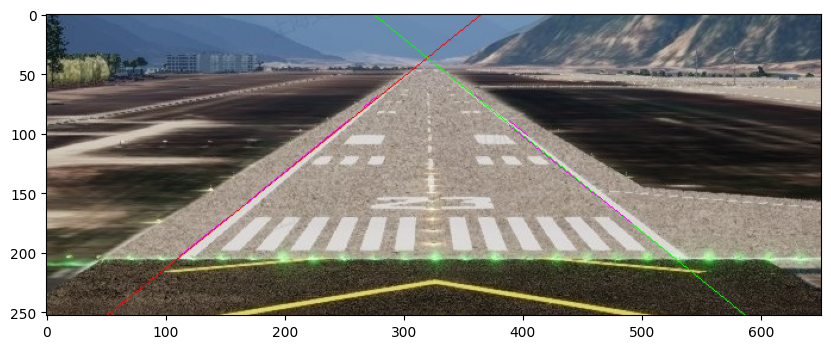

In [3]:
lineImg = img.copy()
theta0, rho0 = computeResult(thetaRhoGrid[max_index[0]][max_index[1]], lineImg, color = (0, 0, 255), draw=True)
theta1, rho1 = computeResult(thetaRhoGrid[second_max_index[0]][second_max_index[1]], lineImg, color = (0, 255, 0), draw=True)
# computeResult(thetaRhoGrid[third_max_index[0]][third_max_index[1]], lineImg, color=(255, 0, 0))

plt.figure(figsize=[10, 10])
plt.imshow(cv2.cvtColor(lineImg, cv2.COLOR_BGR2RGB))
plt.show()